# Imports

In [1]:
import os
import cv2
import csv
import glob
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter
import albumentations as A
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

<Figure size 1440x720 with 0 Axes>

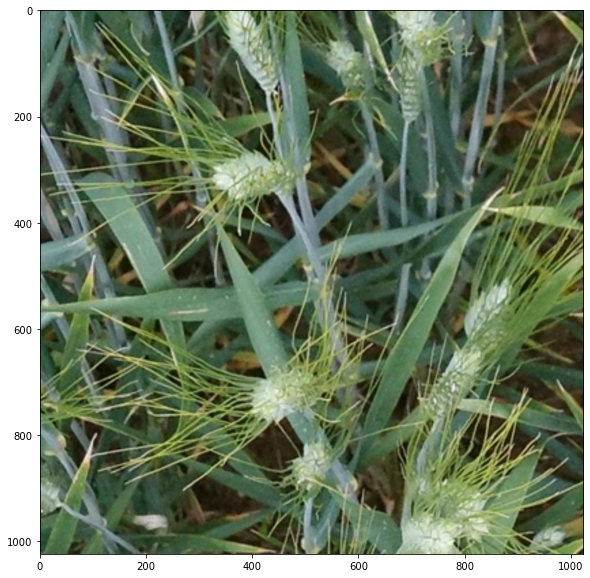

In [2]:
# the following was referenced from reigHns notebooks at: https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes
image_folder_path = "/kaggle/input/global-wheat-detection/train/"
chosen_image = cv2.imread(os.path.join(image_folder_path, "1ee6b9669.jpg"))[:,:,::-1]
plt.figure(figsize = (20,10))
plt.imshow(chosen_image)

# Insect Augmentation

Here, we present the customized PyTorch Albumentations library transformation. Do read the **important remarks** below after the code and images!

In [3]:
from albumentations.core.transforms_interface import ImageOnlyTransform
    
class InsectAugmentation(ImageOnlyTransform):
    """
    Impose an image of a insect to the target image
    -----------------------------------------------
    
    Author(s): Wei Hao Khoong
    Built-upon Roman's AdvancedHairAugmentation in Melanoma competition
    
    Args:
        insects (int): maximum number of insects to impose
        insects_folder (str): path to the folder with insects images
    """

    def __init__(self, insects=2, dark_insect=False, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.insects = insects
        self.dark_insect = dark_insect
        self.insects_folder = "/kaggle/input/bee-augmentation/"

    def apply(self, image, **kwargs):
        """
        Args:
            image (PIL Image): Image to draw insects on.

        Returns:
            PIL Image: Image with drawn insects.
        """
        n_insects = random.randint(1, self.insects) # for this example I put 1 instead of 0 to illustrate the augmentation
        
        if not n_insects:
            return image
        
        height, width, _ = image.shape  # target image width and height
        insects_images = [im for im in os.listdir(self.insects_folder) if 'png' in im]
        
        for _ in range(n_insects):
            insect = cv2.cvtColor(cv2.imread(os.path.join(self.insects_folder, random.choice(insects_images))), cv2.COLOR_BGR2RGB)
            insect = cv2.flip(insect, random.choice([-1, 0, 1]))
            insect = cv2.rotate(insect, random.choice([0, 1, 2]))

            h_height, h_width, _ = insect.shape  # insect image width and height
            roi_ho = random.randint(0, image.shape[0] - insect.shape[0])
            roi_wo = random.randint(0, image.shape[1] - insect.shape[1])
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask 
            img2gray = cv2.cvtColor(insect, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of insect in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of insect from insect image.
            if self.dark_insect:
                img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                insect_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            else:
                insect_fg = cv2.bitwise_and(insect, insect, mask=mask)

            # Put insect in ROI and modify the target image
            dst = cv2.add(img_bg, insect_fg, dtype=cv2.CV_64F)

            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return image 

<Figure size 1440x720 with 0 Axes>

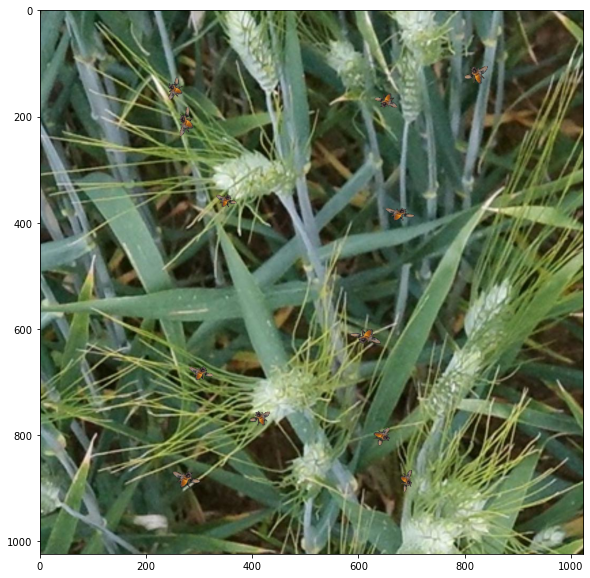

In [4]:
img = InsectAugmentation(insects=2, always_apply=True)(image=chosen_image)['image']
plt.figure(figsize = (20,10))
plt.imshow(img)

<Figure size 1440x720 with 0 Axes>

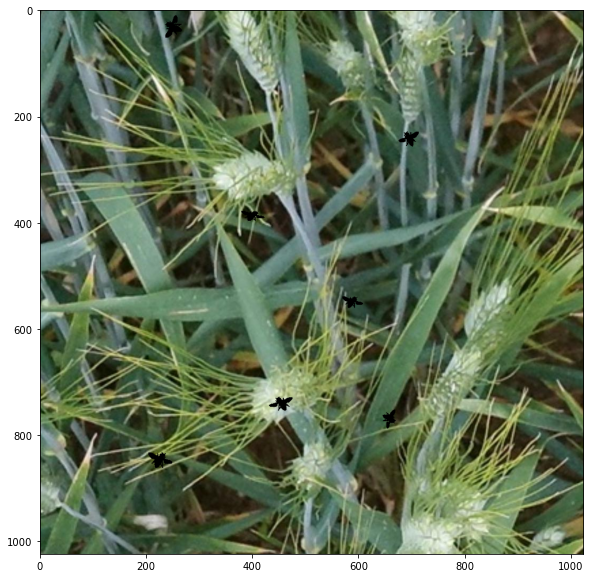

In [5]:
chosen_image = cv2.imread(os.path.join(image_folder_path, "1ee6b9669.jpg"))[:,:,::-1]
img = InsectAugmentation(insects=2, dark_insect=True, always_apply=True)(image=chosen_image)['image']
plt.figure(figsize = (20,10))
plt.imshow(img)

# Important Remarks

- if you decide to create your own customized insect dataset, do bear in mind **not to have very large insects** as they will obscure wheat heads! I tired it at first (with bees half as large as a wheat head and it was a disaster during training)
- **do not set too high a value for the hyperparameter `insects`** as having too many insects will also obscure important information in the images like the wheat heads
- i found that `insects=1` or `insects=2` works best so far on EfficientDet architectures. I used EfficientDet-D6 here only as an example. Feel free to experiement with other EfficientDet architectures or models like Faster R-CNN, Detectron2.

# WBF approach over TTA for single model EfficientDet (Inference)

Firstly, a big thanks to Alex for sharing his great notebooks in the competition, and in others too! :) I've learnt a lot, and I'm sure many others have as well. The rest of the notebook are from Alex's notebooks. Some links to his great work for GWD can be found here:

- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)
- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)
- [[Inference] EfficientDet](https://www.kaggle.com/shonenkov/inference-efficientdet)
- [[OOF-Evaluation][Mixup] EfficientDet](https://www.kaggle.com/shonenkov/oof-evaluation-mixup-efficientdet)
- [[Bayesian optimization WBF] EfficientDet](https://www.kaggle.com/shonenkov/bayesian-optimization-wbf-efficientdet)

## Main Idea (Quoted from Alex)

Today I would like to share with you TTA approach for object detection tasks. 
TTA (Test Time Augmentation) is approach with augmentation of test images. I have created custom TTA API with clear understanding! You can create own TTA approaches using my examples)

For prediction I would like to use single model, that I published earlier.

For ensemble of TTA I would like to use "best of the best" WBF! Author of WBF is really cool russian competitions grandmaster [Roman Solovyev @ZFturbo](https://www.kaggle.com/zfturbo)! 

### If you like his work about WBF, please, add star [github repo](https://github.com/ZFTurbo/Weighted-Boxes-Fusion)!

## Dependencies

In [6]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [7]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import ensemble_boxes
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

In [8]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [9]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [10]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [11]:
!ls ../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin

../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin


In [12]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    #net.load_state_dict(checkpoint)

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_net('../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin')

## Custom TTA API

Idea is simple: 
- `augment` make tta for one image
- `batch_augment` make tta for batch of images
- `deaugment_boxes` return tta predicted boxes in back to original state of image

Also we are interested in `Compose` with combinations of tta :)

In [13]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

## Demonstration how it works

In [14]:
def process_det(index, det, score_threshold=0.33):
    boxes = det[index].detach().cpu().numpy()[:,:4]    
    scores = det[index].detach().cpu().numpy()[:,4]
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
    boxes = (boxes).clip(min=0, max=511).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]
    return boxes, scores

/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


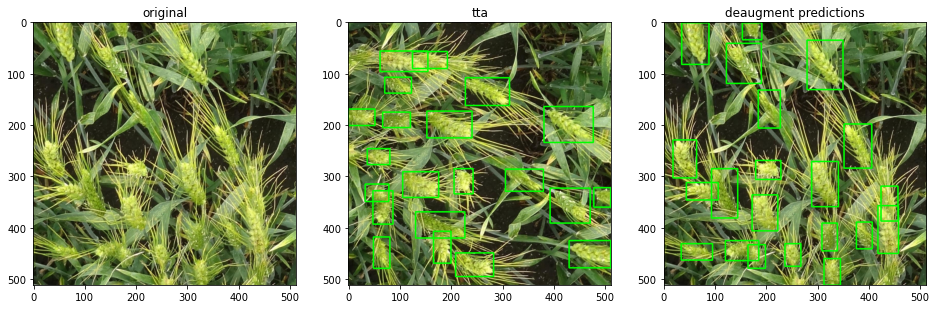

In [15]:
# you can try own combinations:
transform = TTACompose([
    TTARotate90(),
    TTAVerticalFlip(),
])

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

image, image_id = dataset[5]

numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original')

tta_image = transform.augment(image)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()

det = net(tta_image.unsqueeze(0).float().cuda(), torch.tensor([1]).float().cuda())
boxes, scores = process_det(0, det)

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('tta')
    
boxes = transform.deaugment_boxes(boxes)

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax[2].imshow(numpy_image);
ax[2].set_title('deaugment predictions');

## Combinations of TTA

In [16]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), TTARotate180(), TTARotate270(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

## WBF over TTA

In [17]:
def make_tta_predictions(images, score_threshold=0.33):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.6, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

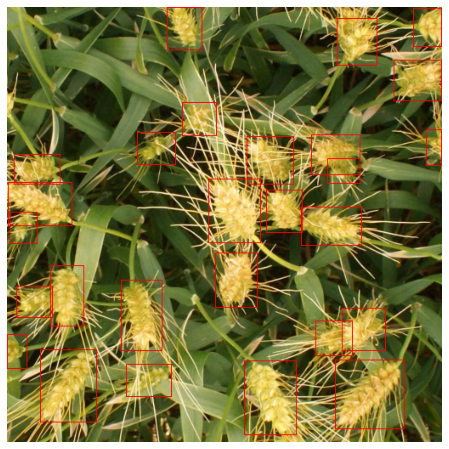

In [18]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

## Inference

In [19]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [20]:
results = []

for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [21]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,796707dd7,0.8999 709 823 111 104 0.8723 894 332 113 93 0...
1,cc3532ff6,0.9600 772 831 163 160 0.9266 910 124 112 95 0...
2,51f1be19e,0.8007 842 268 131 202 0.7976 612 85 151 169 0...
3,51b3e36ab,0.8767 874 291 149 137 0.8746 499 361 311 126 ...
4,f5a1f0358,0.9083 689 204 113 92 0.8983 542 272 112 114 0...
